In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xscen

from clisops.core.subset import subset_shape

from xhydro.pmf.pmf import remove_precip, separate_pr, fix_pmp_year, place_pmf_inputs


* On charge la météo
* On définit la pmp
* On choisit une année de Base
* On place la pmp
* On enlève la précip solide avant
* On enlève la précip solide après
* On instancie un model
* On fait une sim
* On trouve le facteur de neige pour Neige 100
* On applique le facteur 
* On simule
*
*
*
*

# PMF Analysis with Different Tools

In this notebook, we will perform some things that can be done in a Probable Maximum Flood (PMF) analysis. A PMF analysis is not a straigthfoward méthodology, this notebook is thus intended to be an example of different methods. For each methods, we will try to give a breif explanations and highlights its purpose.

---





### 3. **Choose a base year**
   A reference year is selected to align the meteorological data. This ensures that the PMP event is placed in a consistent context, allowing for accurate comparisons and simulations.

   **Purpose**: To provide a baseline for integrating the PMP into the weather data.

---

### 4. **Place the PMP**
   The PMP event is integrated into the weather data at the appropriate time. This step modifies the precipitation data to include the extreme event, ensuring that the PMP is properly represented in the analysis.

   **Purpose**: To simulate the impact of the PMP on the hydrological system.

---

### 5. **Remove solid precipitation before**
   Any solid precipitation (e.g., snow) that occurred before the PMP event is removed. This step isolates the impact of the PMP by eliminating prior snow accumulation.

   **Purpose**: To focus the analysis on the PMP event and its direct effects.

---

### 6. **Remove solid precipitation after**
   Similarly, solid precipitation that occurred after the PMP event is removed. This ensures that the analysis remains centered on the PMP and avoids interference from subsequent snow events.

   **Purpose**: To maintain the integrity of the PMP-focused analysis.

---

### 7. **Instantiate a model**
   A hydrological model is created and configured. This model will simulate the behavior of the hydrological system under the influence of the PMP and other factors.

   **Purpose**: To provide a computational framework for simulating the PMF.

---

### 8. **Run a simulation**
   An initial simulation is performed using the prepared data. This provides a baseline scenario to evaluate the system's response to the PMP.

   **Purpose**: To establish a reference point for further analysis and adjustments.

---

### 9. **Find the snow factor for Snow 100**
   The snow factor for a specific scenario (e.g., Snow 100) is calculated. This involves determining the contribution of snow to the overall hydrological response.

   **Purpose**: To quantify the role of snow in the PMF analysis and adjust the model accordingly.

---

### 10. **Apply the snow factor**
   The calculated snow factor is applied to the data. This step modifies the input data to account for the effects of snow on the hydrological system.

   **Purpose**: To incorporate the snow factor into the analysis and improve the accuracy of the simulation.

---

### 11. **Run the simulation**
   A new simulation is performed with the adjusted data. This step evaluates the hydrological system's response to the PMP, including the effects of the snow factor.

   **Purpose**: To generate the final results of the PMF analysis and assess the system's behavior under extreme conditions.

---

By following these steps, we systematically analyze the Probable Maximum Flood scenario, leveraging various tools and methods to ensure a comprehensive and accurate assessment.

### 1. **Define the PMP**
   Let define some inputs for the PMF, here we'll define :
   * Probable Maximum Precipitation (pmp); 
   * 100 year return period precipitation (p100); 
   * critical temperature sequences (min_temp, mean_temp, max_temp);
   * probable maximum snow accumulation (pmsa);
   * 100 year return period snow (swe100). 

In [3]:


# Define input dictionaries
swe100 = {
    'Catchment-1': 443,
}
pmsa = {
    'Catchment-1': 559,
}
p100 = {
    'Catchment-1': {'J1': 0.19 * 139, 'J2': 0.62 * 139, 'J3': 0.19 * 139},
}
pmp = {
    'C1': {
        'Catchment-1': {'J1': 32.0, 'J2': 191.1, 'J3': 38.8},
    },
    # ... (add all C2 to C10 as in your original pmp dictionary)
}
t_crit_17_31_mai = {
    'max_temp': {
        'Catchment-1': [16.7, 17.3, 17.6, 17.8, 18.0, 18.1, 18.4, 18.8, 26.3, 29.5, 33.3, 20.5, 4.5, 5.0, 4.0],
    },
    'mean_temp': {
        'Catchment-1': [10.8, 10.8, 10.8, 10.8, 10.8, 10.8, 10.9, 11.2, 15.3, 16.9, 18.9, 12.2, 4.5, 5.0, 4.0],
    },
    'min_temp': {
        'Catchment-1': [4.9, 4.3, 4.0, 3.8, 3.6, 3.5, 3.4, 3.6, 4.3, 4.3, 4.5, 3.9, 4.5, 5.0, 4.0],
    }
}

# Prepare arrays and coordinates
bvs = list(swe100.keys())
time = pd.date_range(start='2010-05-17', periods=15, freq='D')
center = list(pmp.keys())

data = {
    'swe100': (['bv'], [swe100[st] for st in bvs]),
    'pmsa': (['bv'], [pmsa[st] for st in bvs]),
    'p100': (['bv', 'time'], np.zeros((len(bvs), 15))),
    'max_temp': (['bv', 'time'], np.zeros((len(bvs), 15))),
    'mean_temp': (['bv', 'time'], np.zeros((len(bvs), 15))),
    'min_temp': (['bv', 'time'], np.zeros((len(bvs), 15))),
    'pmp': (['bv', 'time', 'center'], np.zeros((len(bvs), 15, len(center)))),
}

for i, st in enumerate(bvs):
    data['p100'][1][i, -3:] = [p100[st]['J1'], p100[st]['J2'], p100[st]['J3']]
    data['max_temp'][1][i, :] = t_crit_17_31_mai['max_temp'][st]
    data['mean_temp'][1][i, :] = t_crit_17_31_mai['mean_temp'][st]
    data['min_temp'][1][i, :] = t_crit_17_31_mai['min_temp'][st]
    for j, center_key in enumerate(center):
        data['pmp'][1][i, -3:, j] = [
            pmp[center_key][st]['J1'],
            pmp[center_key][st]['J2'],
            pmp[center_key][st]['J3']
        ]

ds_pmf_inputs = xr.Dataset(data, coords={'bv': bvs, 'time': time, 'center': center})
ds_pmf_inputs


<xarray.Dataset> Size: 788B
Dimensions:    (bv: 1, time: 15, center: 1)
Coordinates:
  * bv         (bv) <U11 44B 'Catchment-1'
  * time       (time) datetime64[ns] 120B 2010-05-17 2010-05-18 ... 2010-05-31
  * center     (center) <U2 8B 'C1'
Data variables:
    swe100     (bv) int64 8B 443
    pmsa       (bv) int64 8B 559
    p100       (bv, time) float64 120B 0.0 0.0 0.0 0.0 ... 0.0 26.41 86.18 26.41
    max_temp   (bv, time) float64 120B 16.7 17.3 17.6 17.8 ... 20.5 4.5 5.0 4.0
    mean_temp  (bv, time) float64 120B 10.8 10.8 10.8 10.8 ... 12.2 4.5 5.0 4.0
    min_temp   (bv, time) float64 120B 4.9 4.3 4.0 3.8 3.6 ... 3.9 4.5 5.0 4.0
    pmp        (bv, time, center) float64 120B 0.0 0.0 0.0 ... 32.0 191.1 38.8

### 2. **Load the weather data**
   In this step, we import the meteorological data required for the analysis. This includes precipitation, temperature, and other relevant variables. The data is typically loaded from a file or a database and is structured to cover the time period of interest. We here choose daily ERA5_land


In [4]:
path_to_file = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/reanalyses/day_ERA5-Land_NAM.ncml"
era = xr.open_dataset(path_to_file)
era = era[["tas", "tasmin","tasmax","pr"]]
era

<xarray.Dataset> Size: 603GB
Dimensions:  (time: 27698, lat: 801, lon: 1700)
Coordinates:
  * lat      (lat) float32 3kB 10.0 10.1 10.2 10.3 10.4 ... 89.7 89.8 89.9 90.0
  * lon      (lon) float32 7kB -179.9 -179.8 -179.7 -179.6 ... -10.2 -10.1 -10.0
  * time     (time) datetime64[ns] 222kB 1950-01-01 1950-01-02 ... 2025-10-31
Data variables:
    tas      (time, lat, lon) float32 151GB ...
    tasmin   (time, lat, lon) float32 151GB ...
    tasmax   (time, lat, lon) float32 151GB ...
    pr       (time, lat, lon) float32 151GB ...
Attributes: (12/27)
    Conventions:             CF-1.9
    cell_methods:            time: mean (interval: 1 day)
    doi:                     https://doi.org/10.24381/cds.e2161bac
    domain:                  NAM
    frequency:               day
    history:                 [2022-12-25 09:07:39.901698] Converted variables...
    ...                      ...
    institute_id:            ECMWF
    dataset_id:              ERA5-Land
    abstract:                ERA5-Land provides hourly high resolution inform...
    dataset_description:     https://www.ecmwf.int/en/era5-land
    attribution:             Contains modified Copernicus Climate Change Serv...
    citation:                Muñoz Sabater, J., (2021): ERA5-Land hourly data...

Lets clip our meteorology on the Kipawa Watershed and lets, only keep 10 years of data

In [5]:
gdf = gpd.read_file('Kipawa_poly.json')
date_debut = '2010-01-01'
date_fin = '2020-01-01'
ds_meteo = subset_shape(era, shape=gdf, start_date=date_debut, end_date=date_fin).mean(dim=['lat', 'lon'])
ds_meteo

<xarray.Dataset> Size: 88kB
Dimensions:  (time: 3653)
Coordinates:
  * time     (time) datetime64[ns] 29kB 2010-01-01 2010-01-02 ... 2020-01-01
Data variables:
    tas      (time) float32 15kB 266.3 254.4 256.2 260.0 ... 268.6 272.7 268.9
    tasmin   (time) float32 15kB 258.0 252.4 253.9 257.9 ... 267.5 271.7 267.2
    tasmax   (time) float32 15kB 271.0 257.4 259.0 262.9 ... 272.1 273.3 271.6
    pr       (time) float32 15kB 4.924e-05 2.923e-05 ... 7.317e-05 1.017e-05

After the clipping, our dataset lost its attribute, lets put them back as we'll need them for unit conversion

In [6]:
for var in ds_meteo:
    ds_meteo[var].attrs = era[var].attrs
ds_meteo

<xarray.Dataset> Size: 88kB
Dimensions:  (time: 3653)
Coordinates:
  * time     (time) datetime64[ns] 29kB 2010-01-01 2010-01-02 ... 2020-01-01
Data variables:
    tas      (time) float32 15kB 266.3 254.4 256.2 260.0 ... 268.6 272.7 268.9
    tasmin   (time) float32 15kB 258.0 252.4 253.9 257.9 ... 267.5 271.7 267.2
    tasmax   (time) float32 15kB 271.0 257.4 259.0 262.9 ... 272.1 273.3 271.6
    pr       (time) float32 15kB 4.924e-05 2.923e-05 ... 7.317e-05 1.017e-05

We put everyhting in °C and mm 

In [7]:
ds_meteo = xscen.utils.change_units(ds_meteo, {"tas": "degC", "tasmin": "degC", "tasmax": "degC","pr": "mm"})
ds_meteo

<xarray.Dataset> Size: 88kB
Dimensions:  (time: 3653)
Coordinates:
  * time     (time) datetime64[ns] 29kB 2010-01-01 2010-01-02 ... 2020-01-01
Data variables:
    tas      (time) float32 15kB -6.838 -18.79 -16.92 ... -4.527 -0.4654 -4.231
    tasmin   (time) float32 15kB -15.12 -20.71 -19.24 ... -5.689 -1.479 -5.977
    tasmax   (time) float32 15kB -2.138 -15.78 -14.11 ... -1.055 0.1627 -1.571
    pr       (time) float32 15kB 4.255 2.526 2.903 1.286 ... 11.69 6.322 0.8785

Our `ds_pmf_inputs` was arbitrarly placed at 2010, if we want to apply the pmp to another year, the function `fix_pmp_year` does just that. For example here 2012. It can be applied on the dataset or on a data array

In [8]:
ds_pmp = fix_pmp_year(ds_pmf_inputs, 2012)
ds_pmp

<xarray.Dataset> Size: 788B
Dimensions:    (bv: 1, time: 15, center: 1)
Coordinates:
  * bv         (bv) <U11 44B 'Catchment-1'
  * time       (time) datetime64[ns] 120B 2012-05-17 2012-05-18 ... 2012-05-31
  * center     (center) <U2 8B 'C1'
Data variables:
    swe100     (bv) int64 8B 443
    pmsa       (bv) int64 8B 559
    p100       (bv, time) float64 120B 0.0 0.0 0.0 0.0 ... 0.0 26.41 86.18 26.41
    max_temp   (bv, time) float64 120B 16.7 17.3 17.6 17.8 ... 20.5 4.5 5.0 4.0
    mean_temp  (bv, time) float64 120B 10.8 10.8 10.8 10.8 ... 12.2 4.5 5.0 4.0
    min_temp   (bv, time) float64 120B 4.9 4.3 4.0 3.8 3.6 ... 3.9 4.5 5.0 4.0
    pmp        (bv, time, center) float64 120B 0.0 0.0 0.0 ... 32.0 191.1 38.8

In [9]:
da_pmp = fix_pmp_year(ds_pmf_inputs['pmp'], 2011)
da_pmp

<xarray.DataArray 'pmp' (bv: 1, time: 15, center: 1)> Size: 120B
array([[[  0. ],
        [  0. ],
        [  0. ],
        [  0. ],
        [  0. ],
        [  0. ],
        [  0. ],
        [  0. ],
        [  0. ],
        [  0. ],
        [  0. ],
        [  0. ],
        [ 32. ],
        [191.1],
        [ 38.8]]])
Coordinates:
  * bv       (bv) <U11 44B 'Catchment-1'
  * center   (center) <U2 8B 'C1'
  * time     (time) datetime64[ns] 120B 2011-05-17 2011-05-18 ... 2011-05-31

To place inputs in the loaded meteorology, both datasets need tha hve matchning names, we also mst decide what we want to put, so in our case we chose pmp instead of p100

In [10]:
pmp = ds_pmf_inputs[['max_temp', 'mean_temp', 'min_temp', 'pmp']].rename({'max_temp':'tasmax', 'min_temp':'tasmin', 'mean_temp':'tas', 'pmp':'pr'})
pmp

<xarray.Dataset> Size: 652B
Dimensions:  (bv: 1, time: 15, center: 1)
Coordinates:
  * bv       (bv) <U11 44B 'Catchment-1'
  * time     (time) datetime64[ns] 120B 2012-05-17 2012-05-18 ... 2012-05-31
  * center   (center) <U2 8B 'C1'
Data variables:
    tasmax   (bv, time) float64 120B 16.7 17.3 17.6 17.8 ... 20.5 4.5 5.0 4.0
    tas      (bv, time) float64 120B 10.8 10.8 10.8 10.8 ... 12.2 4.5 5.0 4.0
    tasmin   (bv, time) float64 120B 4.9 4.3 4.0 3.8 3.6 ... 4.5 3.9 4.5 5.0 4.0
    pr       (bv, time, center) float64 120B 0.0 0.0 0.0 0.0 ... 32.0 191.1 38.8

Now that both datasets have matching variables and units, we can place the inputs in our meteo dataset. 

In [13]:
ds = place_pmf_inputs(pmp, ds_meteo)
ds

<xarray.Dataset> Size: 146kB
Dimensions:  (time: 3653)
Coordinates:
  * time     (time) datetime64[ns] 29kB 2010-01-01 2010-01-02 ... 2020-01-01
Data variables:
    tas      (time) float64 29kB -6.838 -18.79 -16.92 ... -4.527 -0.4654 -4.231
    tasmin   (time) float64 29kB -15.12 -20.71 -19.24 ... -5.689 -1.479 -5.977
    tasmax   (time) float64 29kB -2.138 -15.78 -14.11 ... -1.055 0.1627 -1.571
    pr       (time) float64 29kB 4.255 2.526 2.903 1.286 ... 11.69 6.322 0.8785

We can see tha the pmp was indeed place in may 012

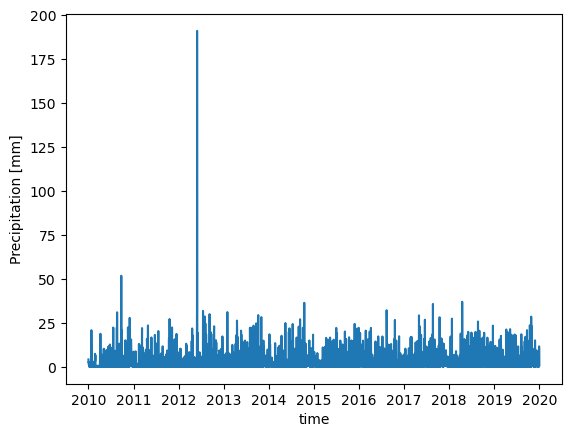

In [14]:
ds.pr.plot()

For the temperature, it's not so obvious, but if we recall, we had this sequence : <br>
**10.8, 10.8, 10.8, 10.8, 10.8, 10.8, 10.9, 11.2, 15.3, 16.9, 18.9, 12.2, 4.5, 5.0, 4.0** from may 17 to mai 31. <br>
Plotting a zoomed period, and showing the sequence beetween the red lines, we see that it's been replaced corectly as well

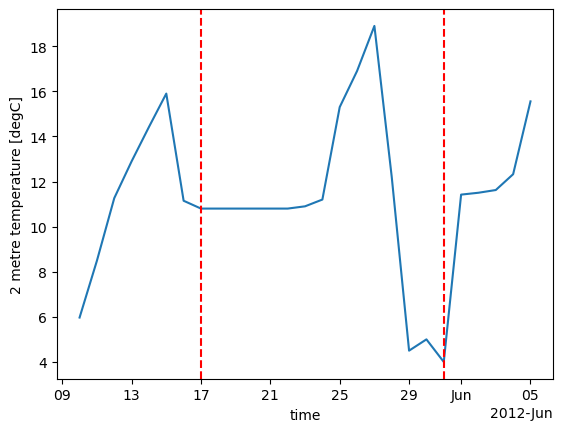

In [21]:


# Plot the data
ax = ds.tas.sel(time=slice('2012-05-10', '2012-06-05')).plot()
may_17 = pd.Timestamp('2012-05-17')
may_31 = pd.Timestamp('2012-05-31')
# Add red dotted vertical lines at May 17 and May 31
plt.axvline(x=may_17, color='red', linestyle='--')
plt.axvline(x=may_31, color='red', linestyle='--')


# Show the plot
plt.show()

Another thing that is often needed if to remove precipitation, it can be used to add a dry perdiod before or after our event <br>
The `remove_precip` function does that, it takes the desired dataarray, a `pandas.date_range`. It would also work on temperature (or any other variable), but I'm not sure when that could be relevant. By default it will only remove for the dates specified, but it can remove specific date everyyear

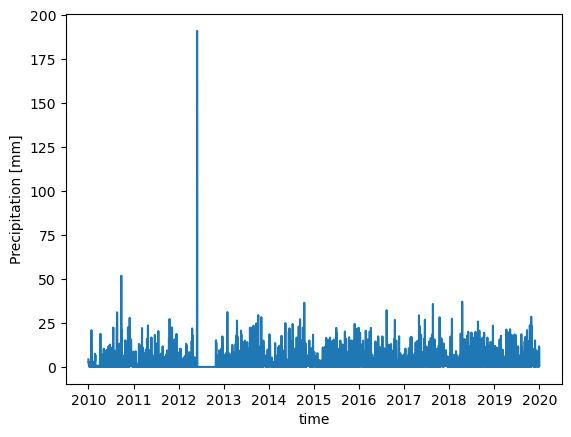

In [26]:
time = pd.date_range(start='2012-06-01', periods=150, freq='D')
remove_precip(ds['pr'], time, each_year=False).plot()

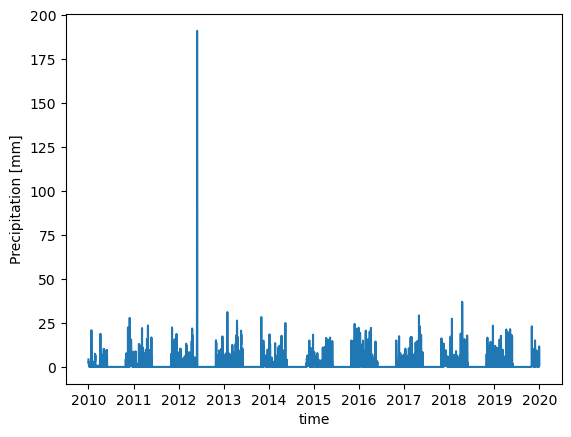

In [27]:
remove_precip(ds['pr'], time, each_year=True).plot()

Depending on the models, you may need to feed it total precipitation or snow and rainfall. While total precipitation is a pretty straigtfooward sum, spliiting precipitation into snow and rain is a litle more compelx. We inplemented two formulas ,to do the splitting <br> The input variable is kept but two new variable appended _rain and _snow are added. The algorithm used and the temperature transition specified is also kept in the metadata. 

In [28]:
separate_pr(ds,'pr','tasmin','tasmax')

<xarray.Dataset> Size: 205kB
Dimensions:  (time: 3653)
Coordinates:
  * time     (time) datetime64[ns] 29kB 2010-01-01 2010-01-02 ... 2020-01-01
Data variables:
    tas      (time) float64 29kB -6.838 -18.79 -16.92 ... -4.527 -0.4654 -4.231
    tasmin   (time) float64 29kB -15.12 -20.71 -19.24 ... -5.689 -1.479 -5.977
    tasmax   (time) float64 29kB -2.138 -15.78 -14.11 ... -1.055 0.1627 -1.571
    pr       (time) float64 29kB 4.255 2.526 2.903 1.286 ... 11.69 6.322 0.8785
    pr_snow  (time) float64 29kB 4.255 2.526 2.903 1.286 ... 11.69 5.696 0.8785
    pr_rain  (time) float64 29kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.6264 0.0